In [166]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as missno

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

from typing import Literal


Options = Literal['mean', 'median', 'std']


cpus = os.cpu_count()
cmap_skyblue = plt.get_cmap('Blues')

In [167]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/45/data.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [168]:
df['num'].unique()  # target

array([0, 2, 1, 3, 4], dtype=int64)

In [169]:
df.rename(columns={'num': 'target'}, inplace=True)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [170]:
def auto_set_or_drop(df: pd.DataFrame, percent: float = 0.5, option: Options = 'std'):
  calc = df.isnull().sum() / df.sum()
  test = calc > percent
  data = test.to_dict()

  for key, upper in data.items():
    if upper:

      # drop it, too much nan!
      df.drop(key, axis=1, inplace=True)
      continue

    # make it noisy!
    df_col = df[key]

    if option == 'mean':
      df_col.fillna(df_col.mean(), inplace=True)

    elif option == 'median':
      df_col.fillna(df_col.median(), inplace=True)

    elif option == 'std':
      df_col.fillna(df_col.std(), inplace=True)

    else:
      df.drop(key, axis=1, inplace=True)
      
  # drop duplicates
  df.drop_duplicates(inplace=True)


auto_set_or_drop(df, percent=0.5, option='std')

In [171]:
df[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


In [172]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [173]:
x = df.drop('target', axis=1).values  # columns selain 'target' + normalization
y = df.iloc[:,-1]  # cuman 'target'

## Make Data It More Balance!

In [174]:
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

x_smote, y_smote = smote.fit_resample(x, y)
x_adasyn, y_adasyn = adasyn.fit_resample(x, y)

<Figure size 1200x400 with 0 Axes>

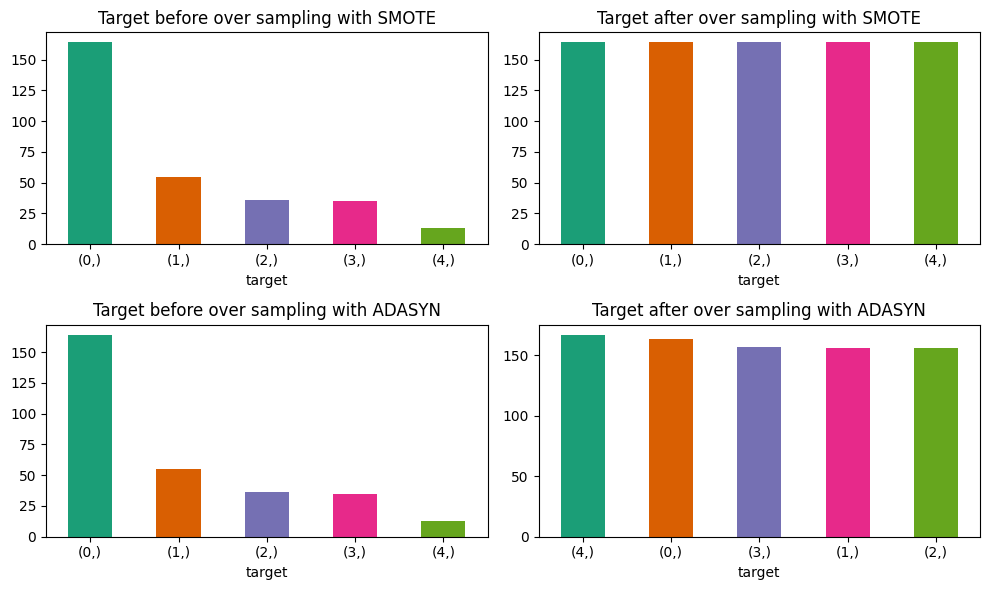

In [221]:
# SMOTE & ADASYN

plt.figure(figsize=(12, 4))
df_y = pd.DataFrame(data=y)

fig, ax = plt.subplots(2, 2)

plt.subplot(2, 2, 1)
df_y.value_counts().plot(kind='bar', figsize=(10, 6), color=sns.palettes.mpl_palette('gray'))
plt.title('Target before over sampling with SMOTE')
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
df_y_smote = pd.DataFrame(data=y_smote)

df_y_smote.value_counts().plot(kind='bar', figsize=(10, 6), color=sns.palettes.mpl_palette('gray'))
plt.title('Target after over sampling with SMOTE')
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
df_y.value_counts().plot(kind='bar', figsize=(10, 6), color=sns.palettes.mpl_palette('gray'))
plt.title('Target before over sampling with ADASYN')
plt.xticks(rotation=0)

plt.subplot(2, 2, 4)
df_y_adasyn = pd.DataFrame(data=y_adasyn)

df_y_adasyn.value_counts().plot(kind='bar', figsize=(10, 6), color=sns.palettes.mpl_palette('gray'))
plt.title('Target after over sampling with ADASYN')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [176]:
# NORMALIZATION

scaler = MinMaxScaler()

x_norm = scaler.fit_transform(x)
x_smote_norm = scaler.fit_transform(x_smote)
x_adasyn_norm = scaler.fit_transform(x_adasyn)

# x -> x_pca
pca = PCA(n_components=1)
pca.fit(x)

x_pca = pca.transform(x)
x_pca = np.concatenate((x_pca, x), axis=1)

# x_pca -> x_pca_norm
scaler = MinMaxScaler()
x_pca_norm = scaler.fit_transform(x_pca)

# x_smote -> x_smote_pca
pca_smote = PCA(n_components=1)
pca_smote.fit(x_smote)

x_smote_pca = pca_smote.transform(x_smote)
x_smote_pca = np.concatenate((x_smote_pca, x_smote), axis=1)

# x_smote_pca -> x_smote_pca_norm
scaler = MinMaxScaler()
x_smote_pca_norm = scaler.fit_transform(x_smote_pca)

# x_adasyn -> x_adasyn_pca
pca_adasyn = PCA(n_components=1)
pca_adasyn.fit(x_adasyn)

x_adasyn_pca = pca_adasyn.transform(x_adasyn)
x_adasyn_pca = np.concatenate((x_adasyn_pca, x_adasyn), axis=1)

# x_adasyn_pca -> x_adasyn_pca_norm
scaler = MinMaxScaler()
x_adasyn_pca_norm = scaler.fit_transform(x_adasyn_pca)

In [177]:
choices = [

  # vanilla family
  ('x', x, y, None),
  ('x_pca', x_pca, y, pca),
  ('x_pca_norm', x_pca_norm, y, pca),
  ('x_norm', x_norm, y, None),

  # smote family
  ('x_smote', x_smote, y_smote, None),
  ('x_smote_pca', x_smote_pca, y_smote, pca_smote),
  ('x_smote_pca_norm', x_smote_pca_norm, y_smote, pca_smote),
  ('x_smote_norm', x_smote_norm, y_smote, None),

  # adasyn family
  ('x_adasyn', x_adasyn, y_adasyn, None),
  ('x_adasyn_pca', x_adasyn_pca, y_adasyn, pca_adasyn),
  ('x_adasyn_pca_norm', x_adasyn_pca_norm, y_adasyn, pca_adasyn),
  ('x_adasyn_norm', x_adasyn_norm, y_adasyn, None),
]

In [178]:
# utilities
from typing import Sequence, Mapping


def evaluation(y_test, y_pred):

  return dict(
      accuracy=accuracy_score(y_test, y_pred),
      recall=recall_score(y_test, y_pred, average='weighted', zero_division=0),
      precision=precision_score(y_test, y_pred, average='weighted', zero_division=0),
      f1_score=f1_score(y_test, y_pred, average='weighted', zero_division=0),
  )


def pprint(data, start = '', end = '\r\n', output = False, tab = '\t'):
  if isinstance(data, Mapping):
    temp = '|' + end
    
    for k, v in data.items():
      temp += start + k + ' = ' + pprint(v, tab + start, end, output=True) + end
    
    if not output:
      print(temp)
      
    return temp

  if not isinstance(data, str):
    if isinstance(data, Sequence):
      temp = '|' + end
      
      for k, v in enumerate(data):
        temp += start + str(k) + ' = ' + pprint(v, tab + start, end, output=True) + end
      
      if not output:
        print(temp)
        
      return temp

  if not output:
    print(data)
    
  return str(data)

In [214]:
def train_models(models, choices = []):
  results = []
  for model_idx, (model_name, model_cb) in enumerate(models):
    print(model_name, '#' + str(model_idx))

    model_results = []
    for choice_idx, (choice_name, x, y, pca) in enumerate(choices):
      print('--', choice_name, '#' + str(choice_idx))

      # splitting data training 80%, and testing 20%
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

      model = model_cb()
      model.fit(x_train, y_train)  # training model

      #? PREDICTION - TESTTING

      y_pred = model.predict(x_test)  # testing model, prediction

      #* FIX y_pred not same a y_test (indexes)

      # make it same as type y_pred and y_test
      y_pred = y_pred.round().astype(y_test.dtype)

      # evaluation
      scores = evaluation(y_test, y_pred)
      pprint(scores, tab='  ')

      # append data results
      model_results.append(dict(
          name=choice_name,
          model=model,
          y_pred=y_pred, y_test=y_test,  # matrix confusion (required)
          scores=scores,
          pca=pca,
      ))

      print('--')
    print()

    results.append(dict(
        name=model_name,
        results=model_results,
    ))

  return results

In [215]:
def get_comparison_from_results(results):
  comparison_values = []

  for result_idx, result in enumerate(results):
    model_name = result.get('name')
    model_results = result.get('results')
    print(model_name, '#' + str(result_idx))

    for choice_idx, choice in enumerate(model_results):
      choice_name = choice.get('name')
      scores = choice.get('scores')
      name = model_name + '_' + choice_name

      print('--', name, '#' + str(choice_idx))
      score = scores.get('f1_score')

      comparison_values.append((name, score))

  comparison = pd.DataFrame(comparison_values, columns=['Model', 'Accuracy'])
  comparison = comparison.sort_values(by='Accuracy', ascending=False)
  comparison.head()

  return comparison

In [216]:
import math
import secrets
import string


def gen_short_name(chars: int = 8):
  return "".join(secrets.choice(string.digits + string.ascii_letters) for _ in range(chars))


def secret_names(names, uniques = []):
  short_names = []
  
  for _ in range(len(names)):
    name = gen_short_name()
    
    while True:  
      if name in uniques:
        name = gen_short_name()
        continue
      
      break
    
    short_names.append(name)
  return short_names


def plot_comparison(comparison: pd.DataFrame, k: int = 12):
  
  n = comparison.values.shape[0]  
  v = math.sqrt(n / k)
  
  rows, cols = math.floor(v), math.ceil(v)
  size = rows + cols
  idx = 0

  fig, ax = plt.subplots(rows, cols, figsize=(rows * 8, cols * 4))
  uniques = []
  links = []

  for i in range(0, n, k):
    names = comparison['Model'].values[i:i+k]
    scores = comparison['Accuracy'].values[i:i+k]
    
    short_names = secret_names(names, uniques)

    link_names = dict(zip(short_names, names))
    links.append(link_names)
    pprint(link_names, tab='  ')

    plt.subplot(rows, cols, idx + 1)
    bars = plt.bar(short_names, scores, color=sns.palettes.mpl_palette('Dark2'))
    idx += 1
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.title('Evaluation')
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')
  
  return links

RandomForestClassifier #0
-- x #0
|
accuracy = 0.5737704918032787
recall = 0.5737704918032787
precision = 0.4852459016393443
f1_score = 0.5250286056484126

--
-- x_pca #1
|
accuracy = 0.5901639344262295
recall = 0.5901639344262295
precision = 0.506167056986729
f1_score = 0.5365027322404372

--
-- x_pca_norm #2
|
accuracy = 0.5901639344262295
recall = 0.5901639344262295
precision = 0.506167056986729
f1_score = 0.5365027322404372

--
-- x_norm #3
|
accuracy = 0.5573770491803278
recall = 0.5573770491803278
precision = 0.4586609800524235
f1_score = 0.5023039432875498

--
-- x_smote #4
|
accuracy = 0.9085365853658537
recall = 0.9085365853658537
precision = 0.9107433217189315
f1_score = 0.908558228819527

--
-- x_smote_pca #5
|
accuracy = 0.8902439024390244
recall = 0.8902439024390244
precision = 0.8913285377093403
f1_score = 0.8900332490719867

--
-- x_smote_pca_norm #6
|
accuracy = 0.8902439024390244
recall = 0.8902439024390244
precision = 0.8913285377093403
f1_score = 0.8900332490719867



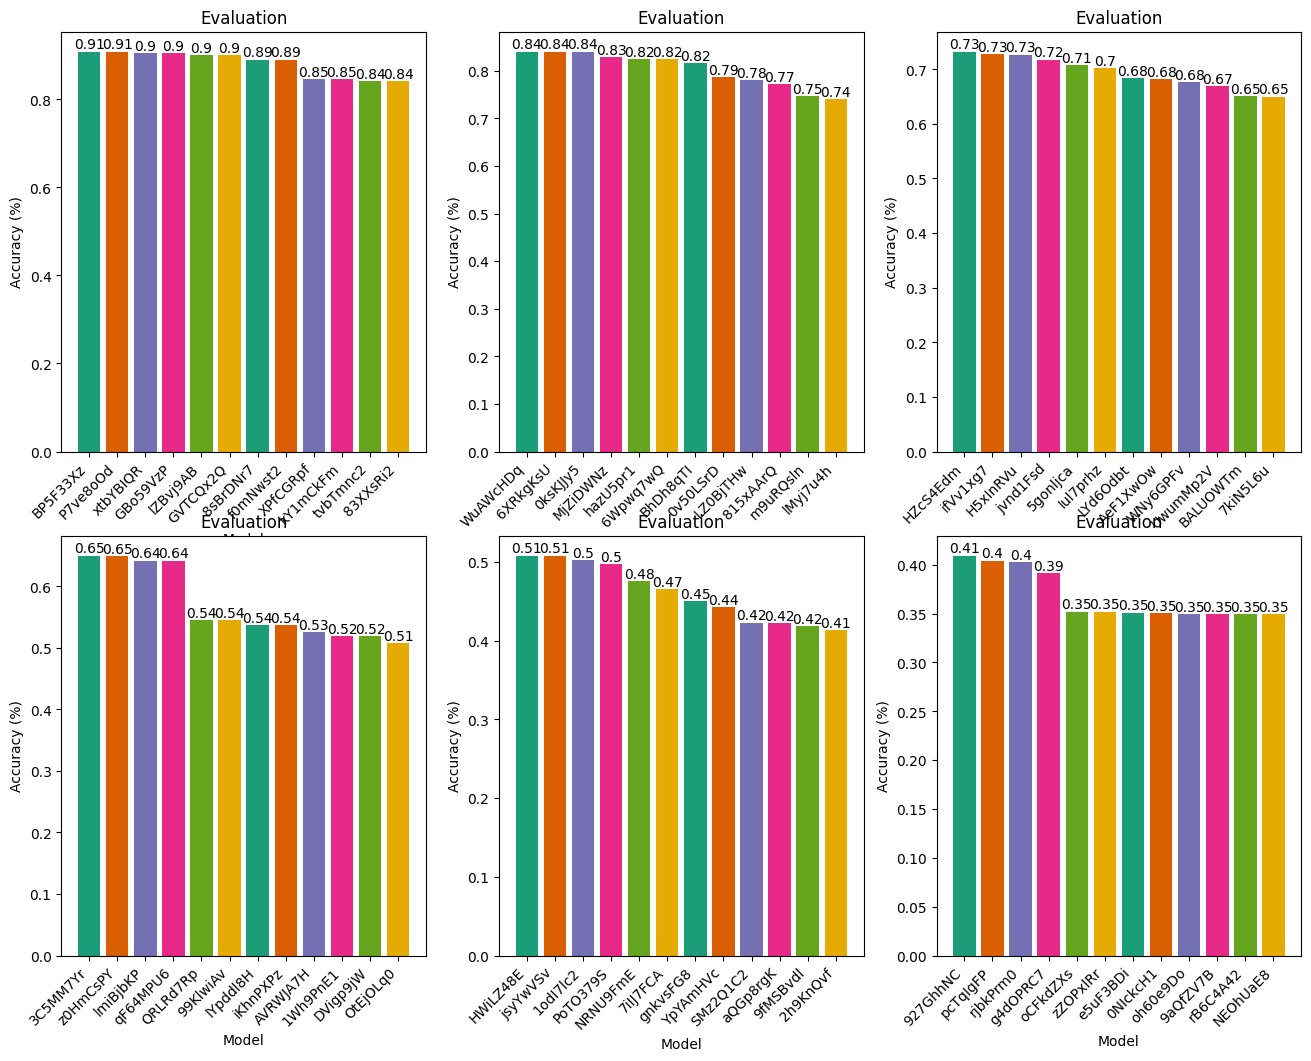

In [217]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier


# model_rf = RandomForestClassifier()
# model_lr = LinearRegression()
# model_knn = KNeighborsClassifier()
# model_dtc = DecisionTreeClassifier()
# model_dtr = DecisionTreeRegressor()
# model_xgb = XGBClassifier()

# param_rf = {
#   'n_estimators': [10, 50, 100, 200], 
#   'max_depth': [None, 3, 5, 10], 
#   'criterion': ['gini', 'entropy'],
# }

# param_lr = {
#   'fit_intercept': [True], 
#   'copy_X': [True], 
#   'positive': [True],
# }

# param_knn = {
#   'n_neighbors': [3, 5, 7, 9], 
#   'weights': ['uniform', 'distance'], 
#   'metric': ['euclidean', 'manhattan', 'minkowski'],
# }

# param_dtc = {
#   'max_depth': [None, 3, 5, 10], 
#   'criterion': ['gini', 'entropy'], 
#   'splitter': ['best', 'random'],
# }

# param_dtr = {
#   'max_depth': [None, 3, 5, 10], 
#   'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 
#   'splitter': ['best', 'random'],
# }

# param_xgb = {
#   'n_estimators': [10, 50, 100, 200], 
#   'max_depth': [3, 5, 10], 
#   'learning_rate': [0.01, 0.1, 0.2, 0.3],
# }

# models = [
#   ('RandomForestClassifier', lambda : GridSearchCV(model_rf, param_rf, scoring="accuracy", cv=5)),
#   ('LinearRegression', lambda : GridSearchCV(model_lr, param_lr, scoring="r2", cv=5)),
#   ('DecisionTreeClassifier', lambda : GridSearchCV(model_dtc, param_dtc, scoring="accuracy", cv=5)),
#   ('DecisionTreeRegressor', lambda : GridSearchCV(model_dtr, param_dtr, scoring="r2", cv=5)),
#   ('KNeighborsClassifier', lambda : GridSearchCV(model_knn, param_knn, scoring="accuracy", cv=5)),
#   ('XGBClassifier', lambda : GridSearchCV(model_xgb, param_xgb, scoring="accuracy", cv=5)),
# ]

models = [
  ('RandomForestClassifier', lambda : RandomForestClassifier(n_estimators=100, random_state=42)),
  ('LinearRegression', lambda : LinearRegression()),
  ('DecisionTreeClassifier', lambda : DecisionTreeClassifier()),
  ('DecisionTreeRegressor', lambda : DecisionTreeRegressor()),
  ('KNeighborsClassifier', lambda : KNeighborsClassifier(n_neighbors=3)),
  ('XGBClassifier', lambda : XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=42)),
]

results = train_models(models, choices)
comparison = get_comparison_from_results(results)
links = plot_comparison(comparison)
plt.show()

In [218]:
rank_values = [(name.split('_')[0], comparasion['Accuracy'].values[idx]) for idx, name in enumerate(comparasion['Model'].unique())]
rank = pd.DataFrame(rank_values, columns=['Model', 'Accuracy'])
rank.drop_duplicates(subset='Model', inplace=True)
rank

,Model,Accuracy
0,RandomForestClassifier,0.908558
8,XGBClassifier,0.846739
14,KNeighborsClassifier,0.840450
20,DecisionTreeClassifier,0.761380
22,DecisionTreeRegressor,0.745720
47,LinearRegression,0.508083


RandomForestClassifier x_smote
|
accuracy = 0.9085365853658537
recall = 0.9085365853658537
precision = 0.9107433217189315
f1_score = 0.908558228819527



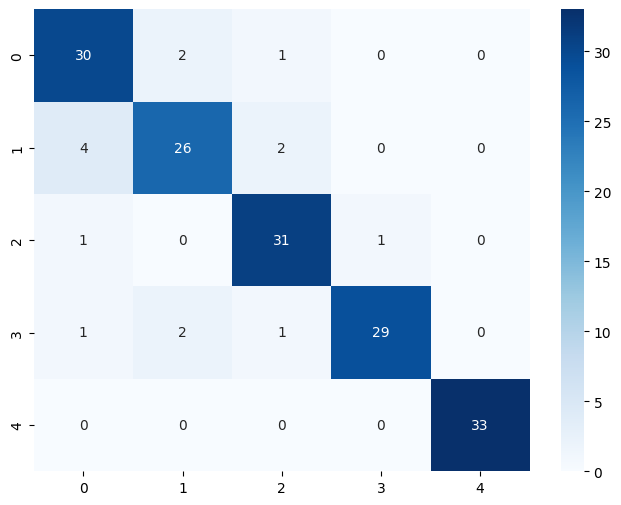

In [219]:
def best_model_from_results(results):
  max_accuracy = 0.0
  model_selected = None
  choice_selected = None

  for model_idx, model in enumerate(results):
    model_results = model.get('results')
    
    for choice_idx, choice in enumerate(model_results):
      scores = choice.get('scores')
      accuracy = scores.get('f1_score')
      
      if max_accuracy < accuracy:
        max_accuracy = accuracy
        model_selected = model
        choice_selected = choice

  return model_selected, choice_selected, max_accuracy


model_selected, choice_selected, max_accuracy = best_model_from_results(results)


if model_selected is not None:
  if choice_selected is not None:
    name = model_selected.get('name')
    choice_name = choice_selected.get('name')
    
    scores = choice_selected.get('scores')
    y_pred = choice_selected.get('y_pred')
    y_test = choice_selected.get('y_test')
    
    print(name, choice_name)
    pprint(scores, tab='  ')
    
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_skyblue)
    
    plt.show()
  

In [220]:
pprint(dict(
  model=choice_selected.get('model'),
  pca=choice_selected.get('pca'),
  is_norm=choice_selected.get('name').endswith('_norm'),
))

|
model = RandomForestClassifier(random_state=42)
pca = None
is_norm = False



'|\r\nmodel = RandomForestClassifier(random_state=42)\r\npca = None\r\nis_norm = False\r\n'